# Load data 

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from apricot import FacilityLocationSelection
import hdbscan
from sklearn.datasets import make_blobs

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

import math

from common import load_data, split_data, data_selection

### Import data

In [3]:
data_dir = "../data/"
full_data = load_data(data_dir)

name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = full_data["data"]
inputs_perf = full_data["performance_properties"]
inputs_feat = full_data["features"]
inputs_categ = full_data["features_categorical"]
inputs_num = full_data["features_numerical"]
inputs_feat_cols = full_data["feature_columns"]
inputs_prop = full_data["input_properties"]
inputs_name = full_data["input_names"]
inputs_count = full_data["input_counts"]

random_seed = 100
system = "gcc"
train_data, test_data, _ , _ = split_data(
    data, system, inputs_count, inputs_feat_cols, random_seed
)

np.random.seed(random_seed)

valid_training_percentages = [(k+1)/10 for k in range(9)] # 0.1 -> 0.9 included

train = dict()
val = dict()

inputs_prop_categ = dict()
inputs_prop_categ["gcc"] = []
inputs_prop_categ["imagemagick"] = ["description"]
inputs_prop_categ["nodejs"] = []
inputs_prop_categ["poppler"] = []
inputs_prop_categ["xz"] = ["type"]
inputs_prop_categ["x264"] = ["category"]
inputs_prop_categ["lingeling"] = []
inputs_prop_categ["sqlite"] = []

data_with_props = dict()
props = dict()
cols = dict()

for ns in name_systems:
    props[ns] = pd.get_dummies(pd.read_csv("../data/"+ns+"/others/properties.csv").set_index("id").drop(["name"], 
                                                                                                    axis = 1), 
                           columns = inputs_prop_categ[ns]).fillna(0)
    df = data[ns, 0]
    cols[ns] = tuple(props[ns].columns)+tuple(df.columns)

for dkey in data.keys():
    ns, input_id = dkey
    df = data[dkey]
    prop_inp = tuple(props[ns].iloc[input_id])
    data_with_props[ns, input_id] = pd.DataFrame([tuple(prop_inp) + tuple(df.iloc[i]) for i in range(df.shape[0])], 
                                                 columns = cols[ns])

train_props = dict()
val_props = dict()

for dkey in data.keys():
    soft, input_id = dkey
    for p in valid_training_percentages:
        X_train, X_test = train_test_split(data[soft, input_id], train_size=p)
        train[soft, input_id, p] = X_train
        val[soft, input_id, p] = X_test
        X_train_props, X_test_props = train_test_split(data_with_props[soft, input_id], train_size=p)
        train_props[soft, input_id, p] = X_train_props
        val_props[soft, input_id, p] = X_test_props

In [4]:
train_props["x264", 0, 0.1]

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category_Animation,category_CoverSong,category_Gaming,...,scenecut_0,scenecut_40,scenecut_None,weightb_1,weightb_None,size,kbs,fps,etime,cpu
73,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,386720.0,154.53,338.02,2.40,845.0
58,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,214092.0,85.55,273.12,2.83,943.0
155,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,270844.0,108.23,290.15,2.72,554.0
132,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,250420.0,100.07,283.60,2.76,562.0
84,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,237461.0,94.89,88.30,7.33,573.0
129,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,258298.0,103.22,278.81,2.82,508.0
74,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,185351.0,74.07,215.58,3.44,725.0
122,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,362215.0,144.74,377.10,2.23,387.0
149,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,412369.0,164.78,300.74,2.66,585.0
33,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,399812.0,159.77,407.37,2.14,399.0


# Select indexes of inputs with different selection techniques

In [33]:
input_nb_list = dict()

input_nb_list["poppler"] = [2, 5, 10, 20, 50, 100, 200, 500, 800, 1000, 1300]
input_nb_list["imagemagick"] = [2, 5, 10, 20, 50, 100, 200, 500, 800]
input_nb_list["sqlite"] = [2, 5, 10, 20, 50, 75, 100, 120]
input_nb_list["lingeling"] = [2, 5, 10, 20, 50, 100, 150, 200]
input_nb_list["gcc"] = [2, 5, 10, 20, 25]
input_nb_list["nodejs"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500]
input_nb_list["xz"] = [2, 5, 10, 25, 30]
input_nb_list["x264"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000]

is_techniques = ["random", "kmeans", "submodular", "hdbscan"]

inputs_indexes = dict()

for ns in name_systems:
    for nb_inp in input_nb_list[ns]:
        # pick nb_inp inputs randomly
        inputs_indexes[ns, "random", nb_inp] = np.random.choice([k for k in range(inputs_count[ns])], nb_inp)
        # pick center of clusters with kmeans
        inputs_indexes[ns, "kmeans", nb_inp]  = []
        clusterer = KMeans(n_clusters=nb_inp, random_state=random_seed)
        df = props[ns]
        clusterer.fit(props[ns])
        inputs_indexes[ns, "kmeans", nb_inp] = clusterer.transform(df).argmin(axis=0)
        # cluster_labels = clusterer.predict(df)
        #dist to center of the cluster
        # df["dist"] = clusterer.inertia_
        # df["label"] = cluster_labels
        # labs = pd.Series(cluster_labels).unique()
        # nb_inp_per_cluster = int(nb_inp/len(labs))
        # nb_cluster_with_one_addi_input = nb_inp%len(labs)
        # for i in range(len(labs)):
        #     lab = labs[i]
        #     df2 = df.query("label=='"+str(lab)+"'")
        #     df2 = df2.sort_values(by="dist", ascending = True)
        #     if i>=nb_cluster_with_one_addi_input:
        #         inputs_indexes[ns, "kmeans", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster])
        #     else:
        #         inputs_indexes[ns, "kmeans", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster+1])
        # submodular
        X = props[ns]
        fls = FacilityLocationSelection(
            nb_inp,
            metric="euclidean",
            optimizer="lazy",
            random_state=random_seed,
        ).fit(X)
        result = X.iloc[fls.ranking]
        inputs_indexes[ns, "submodular", nb_inp] = [k for k in result.index]
        # hdbscan
        inputs_indexes[ns, "hdbscan", nb_inp]  = []
        clusterer = hdbscan.HDBSCAN()
        df = props[ns]
        cluster_labels = clusterer.fit_predict(props[ns])
        df["probs"] = clusterer.probabilities_
        df["label"] = cluster_labels
        labs = pd.Series(cluster_labels).unique()
        nb_inp_per_cluster = int(nb_inp/len(labs))
        nb_cluster_with_one_addi_input = nb_inp%len(labs)
        for i in range(len(labs)):
            lab = labs[i]
            df2 = df[df.label==lab]
            df2 = df2.sort_values(by="probs", ascending = False)
            if i>=nb_cluster_with_one_addi_input:
                inputs_indexes[ns, "hdbscan", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster])
            else:
                inputs_indexes[ns, "hdbscan", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster+1])

#### The indexes of inputs selected for the software system x264, with the hdbscan input selection technique and 10 inputs as budget

In [49]:
inputs_indexes["x264", "hdbscan", 10]

[]

### Compare different (offline) input selection strategies

In [7]:
res_rq2 = dict()

for ns in name_systems:
    #ns = "x264"

    list_df = []
    for i in range(1, inputs_count[ns]):
        df = data_with_props[ns, i]
        df["input_id"] = i
        #for col in df.columns:
        #    df[col] = (df[col]-np.mean(df[col]))/(np.std(df[col])+1e-4)
        for perf in inputs_perf[ns]:
            df[perf] = (df[perf]-np.mean(df[perf]))/np.std(df[perf])
        list_df.append(df)
    final = pd.concat(list_df).fillna(0)

    for perf in inputs_perf[ns]:
        #perf = "size"
        
        other_perf = [perf for perf in inputs_perf[ns]]
        other_perf.remove(perf)
        other_perf.append("input_id")

        for nb_inp in input_nb_list[ns]:
            #nb_inp = 10
            
            for ist in is_techniques:
                #ist = "random"
                
                try:
                    res = []
                    
                    for i in range(20):
                        inp_ind = inputs_indexes[ns, ist, nb_inp]
                        s = "["
                        for ii in inp_ind:
                            s+=str(ii)+","
                        s=s[:-1]+"]"

                        df_train = final.query("input_id in"+s).drop(other_perf, axis=1)
                        X_train = df_train.drop([perf], axis = 1)
                        y_train = df_train[perf]

                        df_test = final.query("input_id not in"+s).drop(other_perf, axis=1)
                        X_test = df_test.drop([perf], axis = 1)
                        y_test = df_test[perf]

                        dt = DecisionTreeRegressor()
                        dt.fit(X_train, y_train)
                        y_pred = dt.predict(X_test)
                        
                        res.append(mean_absolute_error(y_pred, y_test))

                    res_rq2[ns, perf, nb_inp, ist] = np.mean(res)
                    
                except Exception as e:
                    print(ns, perf, nb_inp, ist, e)

nodejs ops 2 hdbscan
nodejs ops 5 hdbscan
nodejs ops 10 hdbscan
nodejs ops 25 hdbscan
nodejs ops 50 hdbscan
nodejs ops 100 hdbscan
nodejs ops 200 hdbscan
nodejs ops 300 hdbscan
nodejs ops 500 hdbscan
nodejs ops 1000 hdbscan
nodejs ops 1500 hdbscan
poppler size 2 hdbscan
poppler size 5 hdbscan
poppler size 10 hdbscan
poppler size 20 hdbscan
poppler size 50 hdbscan
poppler size 100 hdbscan
poppler size 200 hdbscan
poppler size 500 hdbscan
poppler size 800 hdbscan
poppler size 1000 hdbscan
poppler size 1300 hdbscan
poppler time 2 hdbscan
poppler time 5 hdbscan
poppler time 10 hdbscan
poppler time 20 hdbscan
poppler time 50 hdbscan
poppler time 100 hdbscan
poppler time 200 hdbscan
poppler time 500 hdbscan
poppler time 800 hdbscan
poppler time 1000 hdbscan
poppler time 1300 hdbscan
xz size 2 hdbscan
xz size 5 hdbscan
xz size 10 hdbscan
xz size 25 hdbscan
xz size 30 hdbscan
xz time 2 hdbscan
xz time 5 hdbscan
xz time 10 hdbscan
xz time 25 hdbscan
xz time 30 hdbscan
x264 size 2 hdbscan
x264 s

In [11]:
res_rq2

{('nodejs', 'ops', 2, 'random'): 0.578566736554856,
 ('nodejs', 'ops', 2, 'kmeans'): 0.56718481954781,
 ('nodejs', 'ops', 2, 'submodular'): 0.5593618886813038,
 ('nodejs', 'ops', 5, 'random'): 0.888969359673051,
 ('nodejs', 'ops', 5, 'kmeans'): 0.6339559833609774,
 ('nodejs', 'ops', 5, 'submodular'): 0.5652035798727264,
 ('nodejs', 'ops', 10, 'random'): 0.5922807804249165,
 ('nodejs', 'ops', 10, 'kmeans'): 0.7150101506925619,
 ('nodejs', 'ops', 10, 'submodular'): 0.561717916310111,
 ('nodejs', 'ops', 25, 'random'): 0.6369154625918395,
 ('nodejs', 'ops', 25, 'kmeans'): 0.7826541666578589,
 ('nodejs', 'ops', 25, 'submodular'): 0.7971128174242856,
 ('nodejs', 'ops', 50, 'random'): 0.6923802518323686,
 ('nodejs', 'ops', 50, 'kmeans'): 0.6163465592987791,
 ('nodejs', 'ops', 50, 'submodular'): 0.80091609772666,
 ('nodejs', 'ops', 100, 'random'): 0.5592540142056175,
 ('nodejs', 'ops', 100, 'kmeans'): 0.5660345608796079,
 ('nodejs', 'ops', 100, 'submodular'): 0.6434779213280651,
 ('nodejs', 'o

In [12]:
rq2_lines = []

for mae in res_rq2.keys():
    ns, perf, nb_inp, ist = mae
    rq2_lines.append((ns, perf, nb_inp, ist, res_rq2[mae]))
    
final_rq2 = pd.DataFrame(rq2_lines, columns = ["soft", "perf", "nb_inputs", "is_tech", "mae"])
final_rq2.to_csv("../results/RQ2_data.csv")

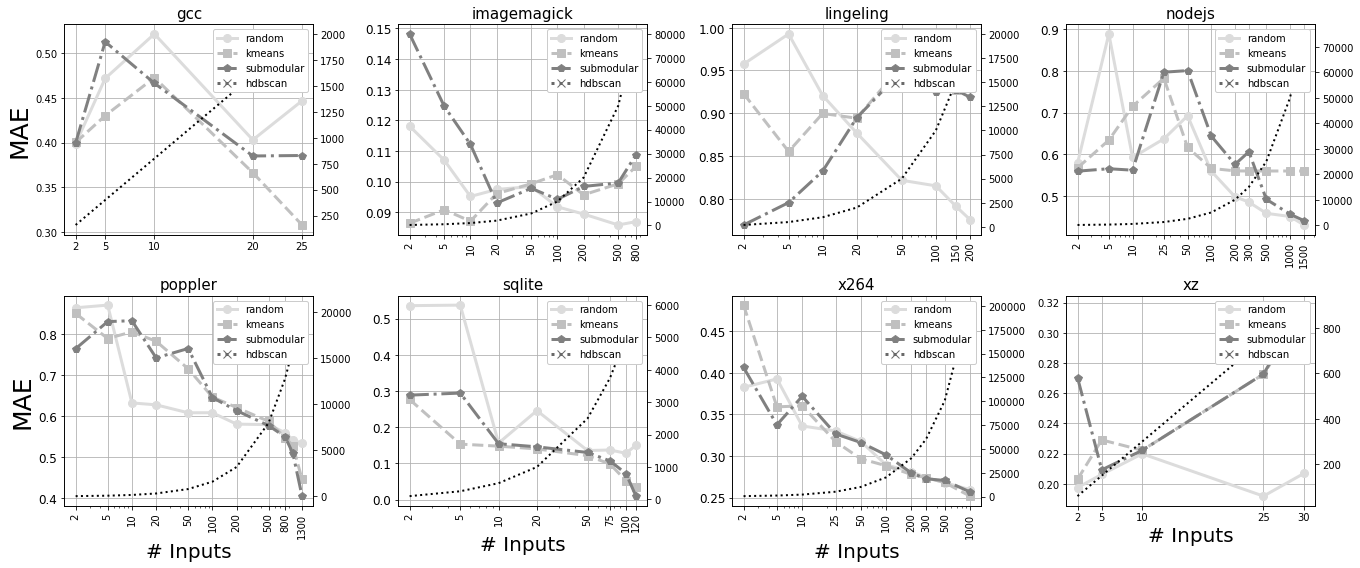

In [32]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(19, 8)

linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
colors = ["gainsboro", "silver", "gray", "dimgray"]
markers = ['o', 's', 'p', 'x']

for i in range(len(name_systems)):
    ns = sorted(name_systems)[i]

    # Draw a nested boxplot to show bills by day and time
    for j in range(len(is_techniques)):
        ist = is_techniques[j]
        tab = [np.mean([res_rq2[k] for k in res_rq2.keys() if k[2]==nb_inp and k[0]==ns and k[3] == ist]) for nb_inp in input_nb_list[ns]]
        axs[int(i/4), i%4].plot(input_nb_list[ns], tab, linewidth=3, linestyle = linestyles[j],
                                marker = markers[j], markersize = 8, label=ist, color=colors[j])

    dataset_sizes = [s*len(data_with_props[ns, 0]) for s in input_nb_list[ns]]
    ax_2 = axs[int(i/4), i%4].twinx()
    ax_2.plot(input_nb_list[ns], dataset_sizes, linewidth=2, linestyle = ":",
                                color="k")  # marker = markers[j], markersize = 8, label=ist, 

    axs[int(i/4), i%4].set_title(ns, fontsize =15)
    axs[int(i/4), i%4].grid(axis="both")
    #axs[i%4, int(i/4)].set_ylim(0, np.percentile(final_rq2.query("soft=='"+soft+"'")["val"], 95))
    legend_1 = axs[int(i/4), i%4].legend(fontsize=10, loc = 'upper right', framealpha=1)
    legend_1.remove()
    ax_2.add_artist(legend_1)
    # ax_2.tick_params(axis='y', which='both', labelsize=12)

    if i >=4:
        axs[int(i/4), i%4].set_xlabel("# Inputs", size = 20)
    else:
        axs[int(i/4), i%4].set_xlabel("")
    if i%4==0:
        axs[int(i/4), i%4].set_ylabel("MAE", size = 25)
    if ns in ["xz", 'gcc']:
        #axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].get_xaxis().get_minor_formatter().labelOnlyBase = False
        axs[int(i/4), i%4].set_xticks(input_nb_list[ns], minor= False)
    elif ns == "poppler":
        axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].set_xticks([2, 5, 10, 20, 50, 100, 200, 500, 800, 1300], minor= False)
        axs[int(i/4), i%4].tick_params(axis='x', labelrotation= 90)
        axs[int(i/4), i%4].tick_params(axis='y', which='major', labelsize=12)
        axs[int(i/4), i%4].get_xaxis().set_major_formatter(ScalarFormatter())
    else:
        axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].set_xticks(input_nb_list[ns], minor= False)
        axs[int(i/4), i%4].tick_params(axis='x', labelrotation= 90)
        axs[int(i/4), i%4].tick_params(axis='y', which='major', labelsize=12)
        axs[int(i/4), i%4].get_xaxis().set_major_formatter(ScalarFormatter())
        
# Arrow
# plt.arrow(x = 4.5, y = 2, dx= 0, dy = -0.3, head_width = 0.15, head_length = .1, color="orange")
# plt.text(s = "Better", x = 4, y = 1.95, size = 20, color = 'orange')

#plt.xticks(size = 20)
#plt.yticks(size = 20)
plt.tight_layout()
plt.savefig("../results/RQ2_eval_all_2yaxis.png", dpi = 300)
plt.show()

In [19]:
for ns in name_systems:
    print(ns, input_nb_list[ns], )

nodejs [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500] [100, 250, 500, 1250, 2500, 5000, 10000, 15000, 25000, 50000, 75000]
poppler [2, 5, 10, 20, 50, 100, 200, 500, 800, 1000, 1300] [32, 80, 160, 320, 800, 1600, 3200, 8000, 12800, 16000, 20800]
xz [2, 5, 10, 25, 30] [60, 150, 300, 750, 900]
x264 [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000] [402, 1005, 2010, 5025, 10050, 20100, 40200, 60300, 100500, 201000]
gcc [2, 5, 10, 20, 25] [160, 400, 800, 1600, 2000]
lingeling [2, 5, 10, 20, 50, 100, 150, 200] [200, 500, 1000, 2000, 5000, 10000, 15000, 20000]
sqlite [2, 5, 10, 20, 50, 75, 100, 120] [100, 250, 500, 1000, 2500, 3750, 5000, 6000]
imagemagick [2, 5, 10, 20, 50, 100, 200, 500, 800] [200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 80000]
